In [1]:
import cv2
import time
import gymnasium as gym
from gymnasium import spaces
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import numpy as np
from enum import Enum

In [2]:
class Actions(Enum):
    UP = 2
    DOWN = 3
    RIGHT = 0
    LEFT = 1

In [3]:
class GridEnvironment(gym.Env):
    def __init__(self, environment_type):
        self.environment_type = environment_type

        self.environment_width = 4
        self.environment_height = 3

        self.observation_space = spaces.Discrete(self.environment_width * self.environment_height)
        self.action_space = spaces.Discrete(4)

        self.agent_pos = np.asarray([0, 0])
        self.positive_pos = np.asarray([[3, 0],[1,1]])
        self.negative_pos = np.asarray([[0,1],[2,2]])
        self.finish=np.asarray([[3,2]])
        
        self.max_timesteps= 11
        self.timestep=0
        self.state=np.zeros((self.environment_width, self.environment_height))
        self.cumulative_reward = 0

    def reset(self, **kwargs):
        self.timestep = 0
        self.cumulative_reward = 0
        self.agent_pos = np.asarray([0, 0])
        self.finish=np.asarray([[3,2]])
        currentState=0
        info={}
        return currentState,info
    

    def step(self, action):
        
        if action == Actions.RIGHT:
            self.agent_pos[0] += 1  # This action causes the agent to go right.
        if action == Actions.LEFT:
            self.agent_pos[0] -= 1  # This action causes the agent to go left.
        if action == Actions.UP:
            self.agent_pos[1] += 1  # This action causes the agent to go up.
        if action == Actions.DOWN:
            self.agent_pos[1] -= 1  # This action causes the agent to go down.
            
        truncated = True if np.all((self.agent_pos >=0 ) & (self.agent_pos <= 3)) else False
        self.agent_pos[0]=np.clip(self.agent_pos[0], 0, 3)
        self.agent_pos[1]=np.clip(self.agent_pos[1], 0, 2)
        
        self.state=np.zeros((self.environment_width, self.environment_height))
        
        self.state[self.agent_pos[0], self.agent_pos[1]] = 1

        currentState = self.agent_pos[1] * self.environment_width + self.agent_pos[0]
        
        reward=0
        
        if any(np.array_equal(self.agent_pos, pos) for pos in self.positive_pos):
            reward += 5
        if any(np.array_equal(self.agent_pos, pos) for pos in self.finish):
            reward += 7
        if any(np.array_equal(self.agent_pos, pos) for pos in self.negative_pos):
            reward -= 5
            
        self.cumulative_reward += reward
        self.timestep += 1

        # Condition to check for termination (episode is over)
        terminated = True if self.timestep >= self.max_timesteps or np.array_equal(self.finish[0], self.agent_pos) else False

        return currentState, self.cumulative_reward, terminated, truncated

    def render(self, mode='human', plot=False):
        
        fig, ax = plt.subplots(figsize=(10, 8))
        ax.set_xlim(0, 4)
        ax.set_ylim(0, 3)

        def plot_image(plot_pos):
            

            # Initially setting every object to not be plotted.
            plot_agent, plot_positive_reward, plot_negative_reward, plot_goal = \
                False, False, False, False

            # Checking which objects need to be plotted by comparing their positions.
            if np.array_equal(self.agent_pos, plot_pos):
                plot_agent = True
                
            if any(np.array_equal(self.positive_pos[i], plot_pos) for i in range(len(self.positive_pos))):
                plot_positive_reward = True
                
            if any(np.array_equal(self.negative_pos[i], plot_pos) for i in range(len(self.negative_pos))):
                plot_negative_reward = True
                
            if any(np.array_equal(self.finish[i], plot_pos) for i in range(len(self.finish))):
                
                plot_goal = True
                
            
            
            # Plot for Agent.
            if plot_agent and \
                    all(not item for item in
                        [plot_positive_reward, plot_negative_reward, plot_goal]):
                agent = AnnotationBbox(OffsetImage(plt.imread('New folder/agent.png'), zoom=0.60),
                                       np.add(plot_pos, [0.5, 0.5]), frameon=False)
                ax.add_artist(agent)

            # Plot for positive_reward.
            elif plot_positive_reward and \
                    all(not item for item in
                        [plot_agent, plot_negative_reward, plot_goal]):
                positive = AnnotationBbox(OffsetImage(plt.imread('New folder/positive.png'), zoom=0.60),
                                        np.add(plot_pos, [0.5, 0.5]), frameon=False)
                ax.add_artist(positive)

            # Plot for negative_reward.
            elif  plot_negative_reward and \
                    all(not item for item in
                        [plot_agent, plot_positive_reward, plot_goal]):
                negative = AnnotationBbox(OffsetImage(plt.imread('New folder/negative.png'), zoom=0.60),
                                      np.add(plot_pos, [0.5, 0.5]), frameon=False)
                ax.add_artist(negative)

            # Plot for goal.
            elif plot_goal and \
                    all(not item for item in
                        [plot_agent, plot_positive_reward, plot_negative_reward]):
                goal = AnnotationBbox(OffsetImage(plt.imread('New folder/images.jpg'), zoom=0.50),
                                     np.add(plot_pos, [0.5, 0.5]), frameon=False)
        
                ax.add_artist(goal)
                
            # plot for both agent and postive reward
            elif all(item for item in [plot_agent, plot_positive_reward]) and \
                    all(not item for item in
                        [plot_negative_reward, plot_goal]):
                agent_positive = AnnotationBbox(OffsetImage(plt.imread('New folder/agent_positive.png'), zoom=0.55),
                                              np.add(plot_pos, [0.5, 0.5]), frameon=False)
                ax.add_artist(agent_positive)
                
            
            # plot for both agent and negative reward
            elif all(item for item in [plot_agent, plot_negative_reward]) and \
                    all(not item for item in
                        [plot_positive_reward, plot_goal]):
                agent_negative = AnnotationBbox(OffsetImage(plt.imread('New folder/agent_negative.png'), zoom=0.55),
                                              np.add(plot_pos, [0.5, 0.5]), frameon=False)
                ax.add_artist(agent_negative)
            
            # plot for both agent and goal
            elif all(item for item in [plot_agent, plot_goal]) and \
                    all(not item for item in
                        [plot_negative_reward, plot_positive_reward]):
                agent_goal = AnnotationBbox(OffsetImage(plt.imread('New folder/agent_goal.png'), zoom=0.45),
                                              np.add(plot_pos, [0.5, 0.5]), frameon=False)
                ax.add_artist(agent_goal)
                

            

        coordinates_state_mapping_2 = {}
        for j in range(self.environment_height * self.environment_width):
            coordinates_state_mapping_2[j] = np.asarray(
                [j % self.environment_width, int(np.floor(j / self.environment_width))])

        # Rendering the images for all states.
        for position in coordinates_state_mapping_2:
            plot_image(coordinates_state_mapping_2[position])
            

        plt.xticks([0, 1,2,3,4 ])
        plt.yticks([0, 1,2,3])
        plt.grid()

        if plot:  # Displaying the plot.
            plt.show()
        else:  # Returning the preprocessed image representation of the environment.
            fig.canvas.draw()
            img = np.array(fig.canvas.renderer.buffer_rgba())[:, :, :3]
            width = 84
            height = 84
            dim = (width, height)
            # noinspection PyUnresolvedReferences
            preprocessed_image = cv2.resize(img, dim, interpolation=cv2.INTER_AREA)
            plt.show()
            return preprocessed_image

the returned state is 11 is terminated True


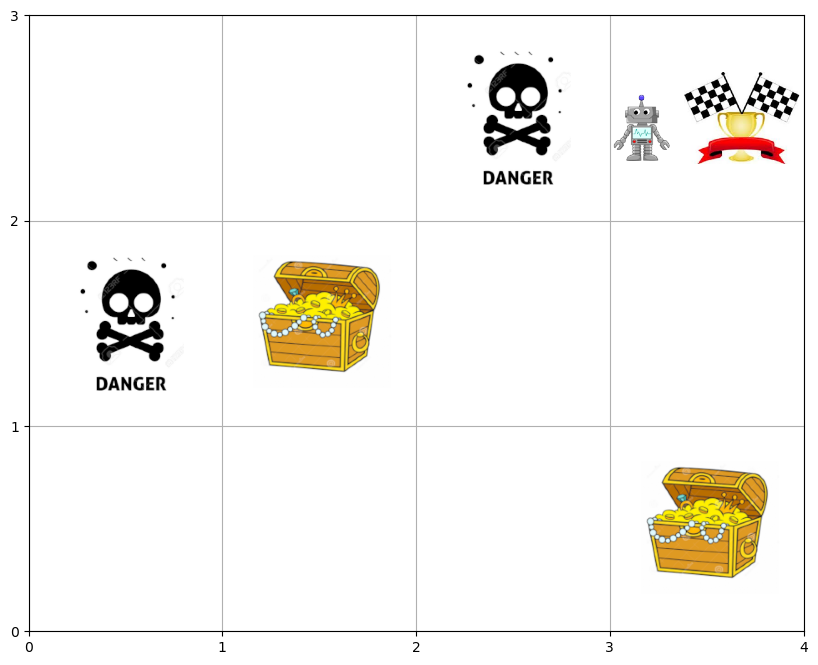

In [4]:
grid_RL = GridEnvironment(environment_type='deterministic')
grid_RL.reset()
obs, reward, terminated, truncated = grid_RL.step(Actions.UP)
obs, reward, terminated, truncated = grid_RL.step(Actions.UP)
obs, reward, terminated, truncated = grid_RL.step(Actions.UP)
obs, reward, terminated, truncated = grid_RL.step(Actions.RIGHT)
obs, reward, terminated, truncated = grid_RL.step(Actions.RIGHT)
obs, reward, terminated, truncated = grid_RL.step(Actions.RIGHT)
# obs, reward, terminated, truncated = grid_RL.step(Actions.RIGHT)
print(f"the returned state is {obs} is terminated {terminated}")
grid_RL.render(plot=True)

In [86]:
def choose_action(env, state, epsilon, Q1, Q2):
    action = 0
    if np.random.uniform(0, 1) < epsilon:
        action = env.action_space.sample()
    else:
        action = np.argmax(Q1[state] + Q2[state])
    return action

def update(state, state2, reward, action, action2, alpha, gamma, Q1, Q2):
    use_Q1 = np.random.rand() < 0.5
    if use_Q1:
        Q_updating = Q1
        Q_referring = Q2
    else:
        Q_updating = Q2
        Q_referring = Q1

    predict = Q_updating[state, action]
    # Round the reward to four decimal places
    rounded_reward = round(reward, 2)
    target = rounded_reward + gamma * Q_referring[state2, np.argmax(Q_updating[state2])]
    # Round the Q-value update to four decimal places
    Q_updating[state, action] = round(Q_updating[state, action] + alpha * (target - predict), 2)

def doDoubleQLearn(epsilon, total_episodes, alpha, gamma, epsilonDecay):
    env = GridEnvironment(environment_type='deterministic')
    Q1 = np.zeros((env.observation_space.n, env.action_space.n))
    Q2 = np.zeros((env.observation_space.n, env.action_space.n))
    print("Initial Q tables")
    print("\n")
    print("Initial Q table 1")
    print(Q1)
    print("\n")
    print("Initial Q table 2")
    print(Q2)
    totalEpisodesRewards = []
    epsilonPerEpisode = []

    for episode in range(total_episodes):
        epsilonPerEpisode.append(epsilon)
        state1, info = env.reset()
        action1 = choose_action(env, state1, epsilon, Q1, Q2)
        terminated, truncated = False, False
        total_reward = 0

        while not terminated:
            state2, reward, terminated, info = env.step(Actions(action1))
            action2 = choose_action(env, state2, epsilon, Q1, Q2)

            update(state1, state2, reward, action1, action2, alpha, gamma, Q1, Q2)
            
            state1 = state2
            action1 = action2
            total_reward += reward

        if epsilon > 0.01:
            epsilon -= epsilonDecay
        totalEpisodesRewards.append(total_reward)
    print("\nTrained Q table")
    print("\n")
    print("Trained Q table 1")
    print(Q1)
    print("\n")
    print("Trained Q table 2")
    print(Q2)

    return Q1, Q2, totalEpisodesRewards, epsilonPerEpisode


Q1, Q2, totalEpisodesRewards, epsilonPerEpisode = doDoubleQLearn(epsilon=1, total_episodes=1000, alpha=0.1, gamma=0.95, epsilonDecay=0.009)


Initial Q tables


Initial Q table 1
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]


Initial Q table 2
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]

Trained Q table


Trained Q table 1
[[289.17   2.2    7.27   7.86]
 [ 11.65 152.24 291.57 159.3 ]
 [ 19.23   0.49   2.57   2.57]
 [  2.02   4.53  10.58   1.46]
 [159.34  -6.06  -2.39  -0.65]
 [ 73.25  29.94  16.12 306.16]
 [  1.74 137.72   0.71   2.5 ]
 [  4.54   3.3   13.21  -0.5 ]
 [ -2.81  -2.71  -3.52  -0.42]
 [  2.09   1.43   0.87  46.75]
 [ -0.47   0.94  -1.5    1.05]
 [  0.     0.     0.     0.  ]]


Trained Q table 2
[[276.69  52.55  20.16  48.2 ]
 [ 15.81 154.57 304.92  77.73]
 [ 14.11   1.21   2.17   5.81]
 [  3.53   0.    14.51   3.63]
 [127.34  -3.76  -5.41   1.

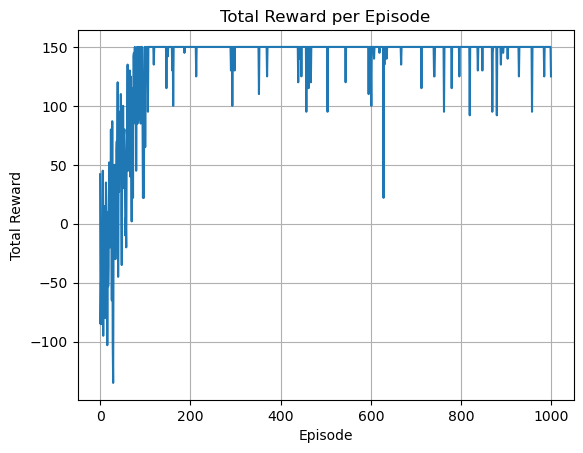

In [87]:
plt.plot(totalEpisodesRewards)
plt.title('Total Reward per Episode')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.grid(True)
plt.show()

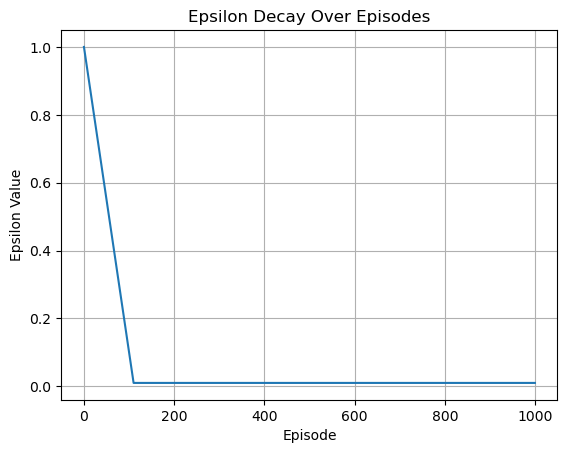

In [88]:
plt.plot(epsilonPerEpisode)
plt.title('Epsilon Decay Over Episodes')
plt.xlabel('Episode')
plt.ylabel('Epsilon Value')
plt.grid(True)
plt.show()

## Step 2.d
### agent is taking only greedy action

In [91]:
print("\nTrained Q tables")
print("Trained Q table 1")
print(Q1)
print("Trained Q table 2")
print(Q2)


Trained Q tables
Trained Q table 1
[[289.17   2.2    7.27   7.86]
 [ 11.65 152.24 291.57 159.3 ]
 [ 19.23   0.49   2.57   2.57]
 [  2.02   4.53  10.58   1.46]
 [159.34  -6.06  -2.39  -0.65]
 [ 73.25  29.94  16.12 306.16]
 [  1.74 137.72   0.71   2.5 ]
 [  4.54   3.3   13.21  -0.5 ]
 [ -2.81  -2.71  -3.52  -0.42]
 [  2.09   1.43   0.87  46.75]
 [ -0.47   0.94  -1.5    1.05]
 [  0.     0.     0.     0.  ]]
Trained Q table 2
[[276.69  52.55  20.16  48.2 ]
 [ 15.81 154.57 304.92  77.73]
 [ 14.11   1.21   2.17   5.81]
 [  3.53   0.    14.51   3.63]
 [127.34  -3.76  -5.41   1.51]
 [ 28.92  59.64  20.77 290.03]
 [  1.02 166.72   0.5    1.35]
 [  1.4    1.55   9.77   3.96]
 [ -2.85  -2.77  -2.81  -1.97]
 [ -2.7   -1.74   0.49 109.61]
 [  0.64   2.18   0.     0.  ]
 [  0.     0.     0.     0.  ]]


In [94]:
def doGreedyActionsWithTwoQs(Q1, Q2):
    total_episodes=10
    env = GridEnvironment(environment_type='deterministic')
    totalEpisodesRewards = []
    for episode in range(total_episodes):
        state1, info = env.reset()
        action1 = np.argmax(Q1[state1] + Q2[state1])
        terminated, truncated = False, False
        total_reward = 0

        while not terminated:
            state2, reward, terminated, info = env.step(Actions(action1))
            action2 = np.argmax(Q1[state2] + Q2[state2])

            state1 = state2
            action1 = action2

            total_reward += reward
        totalEpisodesRewards.append(total_reward)
    return totalEpisodesRewards

In [95]:
totalEpisodesRewards = doGreedyActionsWithTwoQs(Q1, Q2)

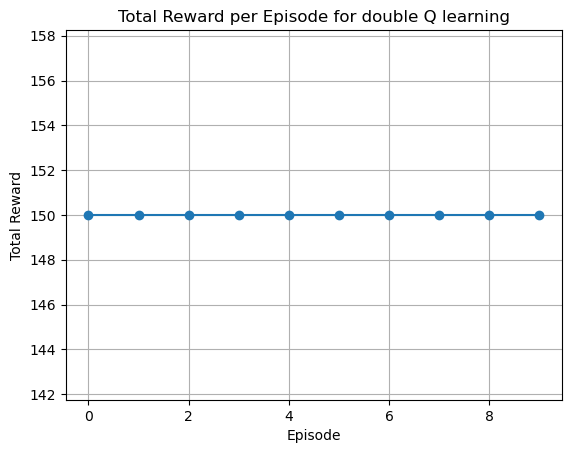

In [96]:
plt.plot(totalEpisodesRewards, marker='o')
plt.title('Total Reward per Episode for double Q learning')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.grid(True)
plt.show()

In [115]:
def drawGraphs(totalEpisodesRewards, epsilonPerEpisode):
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    axs[0].plot(totalEpisodesRewards)
    axs[0].set_title('Total Reward per Episode')
    axs[0].set_xlabel('Episode')
    axs[0].set_ylabel('Total Reward')
    axs[0].grid(True)

    axs[1].plot(epsilonPerEpisode)
    axs[1].set_title('Epsilon Decay Over Episodes')
    axs[1].set_xlabel('Episode')
    axs[1].set_ylabel('Epsilon Value')
    axs[1].grid(True)

    plt.tight_layout()
    plt.show()

def drawGraphForGreedyAction(totalEpisodesRewards):
    plt.plot(totalEpisodesRewards, marker='o')
    plt.title('Total Reward per Episode for only greedy action taken')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.grid(True)
    plt.show()

### 3. Hyper parameter tuning
### First hyper parameter we are choosing is Discount factor (γ) 
#### First try with gamma=0.85

In [111]:
Q1, Q2, totalEpisodesRewards, epsilonPerEpisode = doDoubleQLearn(epsilon = 1, total_episodes=1000, alpha=0.1, gamma=0.85, epsilonDecay=0.009)

Initial Q tables


Initial Q table 1
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]


Initial Q table 2
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]

Trained Q table


Trained Q table 1
[[ 84.16   6.54   2.13   4.39]
 [ 22.69  38.95  98.64  53.08]
 [ 37.1    5.18   5.22   2.45]
 [  2.37  37.38   0.46   5.3 ]
 [ 68.61  -1.65  -1.83  -0.5 ]
 [ 25.42  22.37  25.09 100.01]
 [  1.    46.03   0.57   3.32]
 [  0.5    0.66   1.83   5.52]
 [ -0.74  -1.48  -1.55  -0.15]
 [ -3.16   1.79   1.36  41.07]
 [  2.09   1.08  -0.98   0.11]
 [  0.     0.     0.     0.  ]]


Trained Q table 2
[[ 85.2   15.27   6.54   6.71]
 [ 23.74  39.14 100.09  44.51]
 [ 43.95   2.6    4.24   3.87]
 [  2.41  34.99   2.12   2.47]
 [ 62.99  -2.23  -1.22  -0.

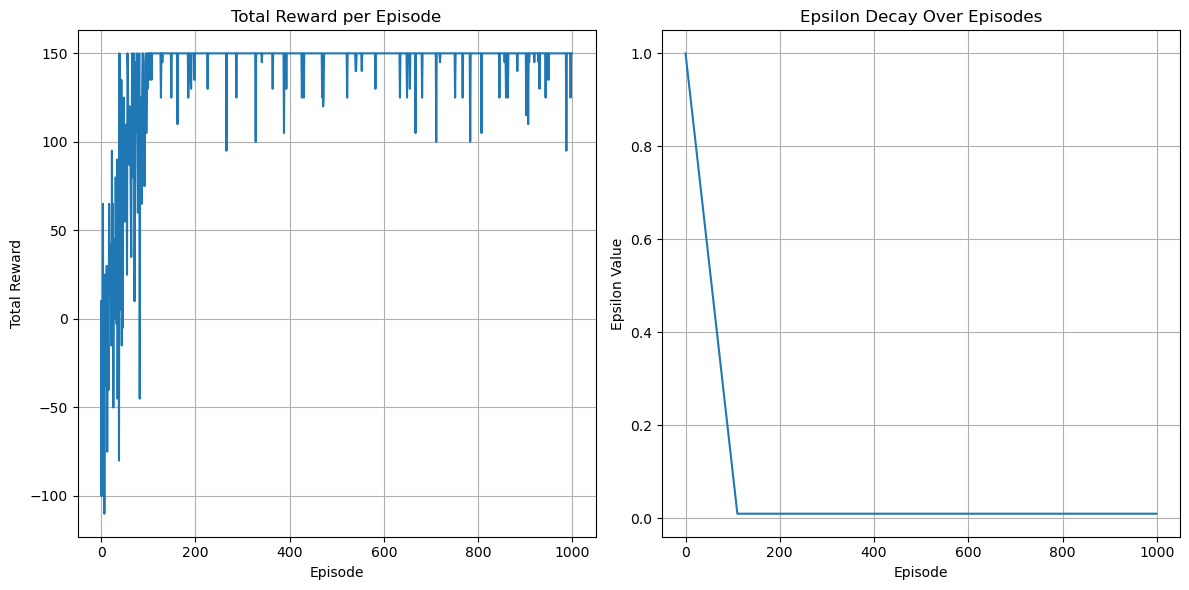

In [112]:
drawGraphs(totalEpisodesRewards, epsilonPerEpisode)

#### in case of only greedy action is taken

In [113]:
totalEpisodesRewards = doGreedyActionsWithTwoQs(Q1, Q2)

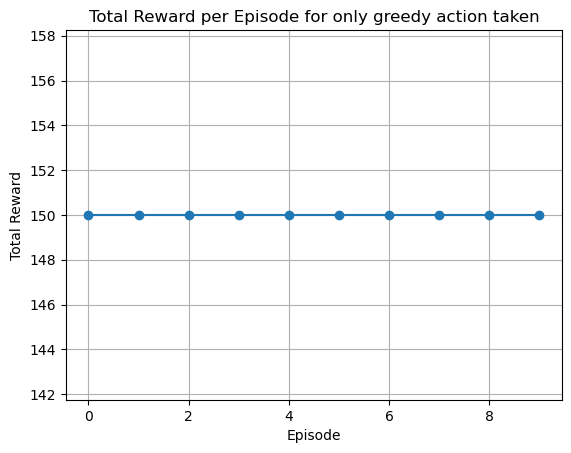

In [116]:
drawGraphForGreedyAction(totalEpisodesRewards)

#### Second try with gamma=0.5

In [117]:
Q1, Q2, totalEpisodesRewards, epsilonPerEpisode = doDoubleQLearn(epsilon = 1, total_episodes=1000, alpha=0.1, gamma=0.5, epsilonDecay=0.009)

Initial Q tables


Initial Q table 1
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]


Initial Q table 2
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]

Trained Q table


Trained Q table 1
[[ 1.500e+01 -1.790e+00 -4.660e+00  1.370e+00]
 [ 1.248e+01  1.580e+01  2.925e+01  1.318e+01]
 [ 2.030e+01  6.900e-01  2.870e+00  4.000e-01]
 [ 1.650e+01  7.540e+00  2.340e+00  4.295e+01]
 [ 2.054e+01 -6.710e+00 -5.800e+00 -3.340e+00]
 [ 1.299e+01  7.300e+00  1.365e+01  2.970e+01]
 [ 3.610e+00  2.204e+01 -5.000e-01  1.530e+00]
 [ 0.000e+00  0.000e+00  0.000e+00  4.400e+00]
 [-3.420e+00 -1.110e+00 -2.540e+00 -2.110e+00]
 [-1.840e+00 -3.640e+00  6.400e-01  1.869e+01]
 [-2.000e-02 -1.000e+00 -3.780e+00 -4.200e-01]
 [ 0.000e+00  0.000e+00  0.

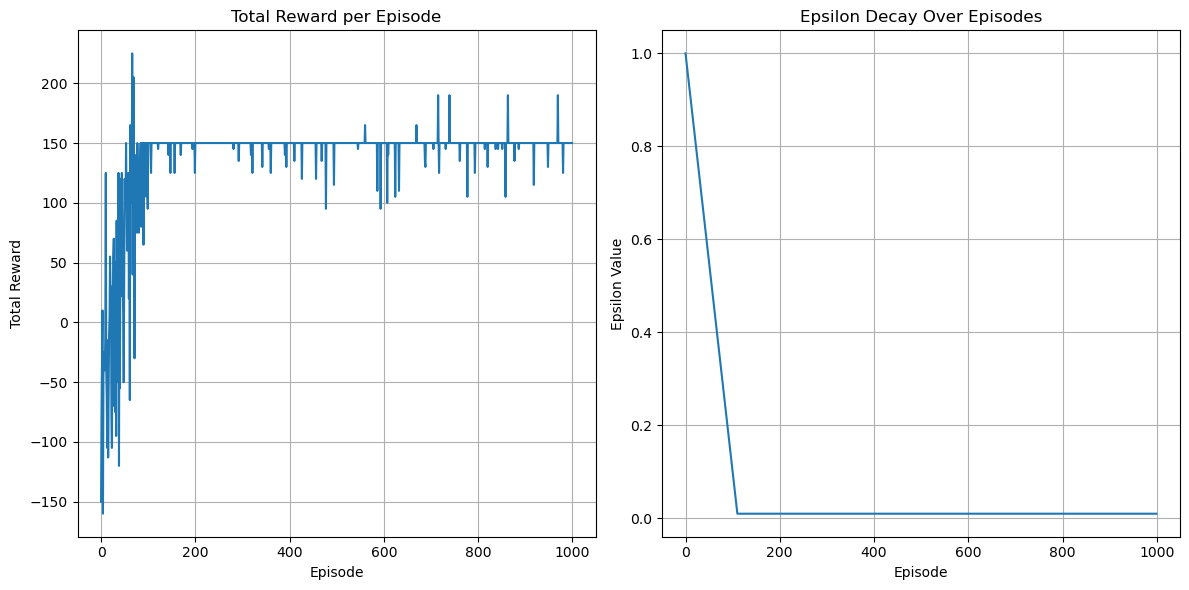

In [118]:
drawGraphs(totalEpisodesRewards, epsilonPerEpisode)

#### in case of only greedy action is taken

In [119]:
totalEpisodesRewards = doGreedyActionsWithTwoQs(Q1, Q2)

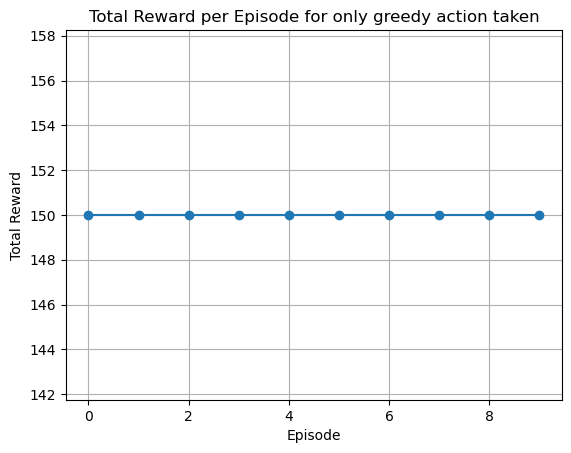

In [120]:
drawGraphForGreedyAction(totalEpisodesRewards)

#### Third try with gamma = 1.5

In [149]:
Q1, Q2, totalEpisodesRewards, epsilonPerEpisode = doDoubleQLearn(epsilon = 1, total_episodes=1000, alpha=0.1, gamma=1.5, epsilonDecay=0.009)

Initial Q tables


Initial Q table 1
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]


Initial Q table 2
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]

Trained Q table


Trained Q table 1
[[ 1.10690712e+45  6.57778992e+24  6.96792097e+09  1.67345761e+33]
 [ 7.72000000e+00  7.26000000e+00  2.19709453e+45  1.28016425e+37]
 [ 3.37810000e+02  1.56700000e+01  1.28900000e+01  9.90000000e-01]
 [ 1.33900000e+01  7.57000000e+00  0.00000000e+00  9.31150000e+02]
 [ 1.70737915e+20 -7.21000000e+00 -1.86000000e+00 -6.20000000e-01]
 [ 5.06396748e+45  4.23261673e+16  1.82060948e+27  2.48412523e+25]
 [ 1.60600000e+01  4.48576325e+45  1.47334278e+27  9.60200000e+01]
 [ 1.32000000e+00  5.30000000e-01  1.41000000e+01  1.00000000e+00]
 [ 7.220

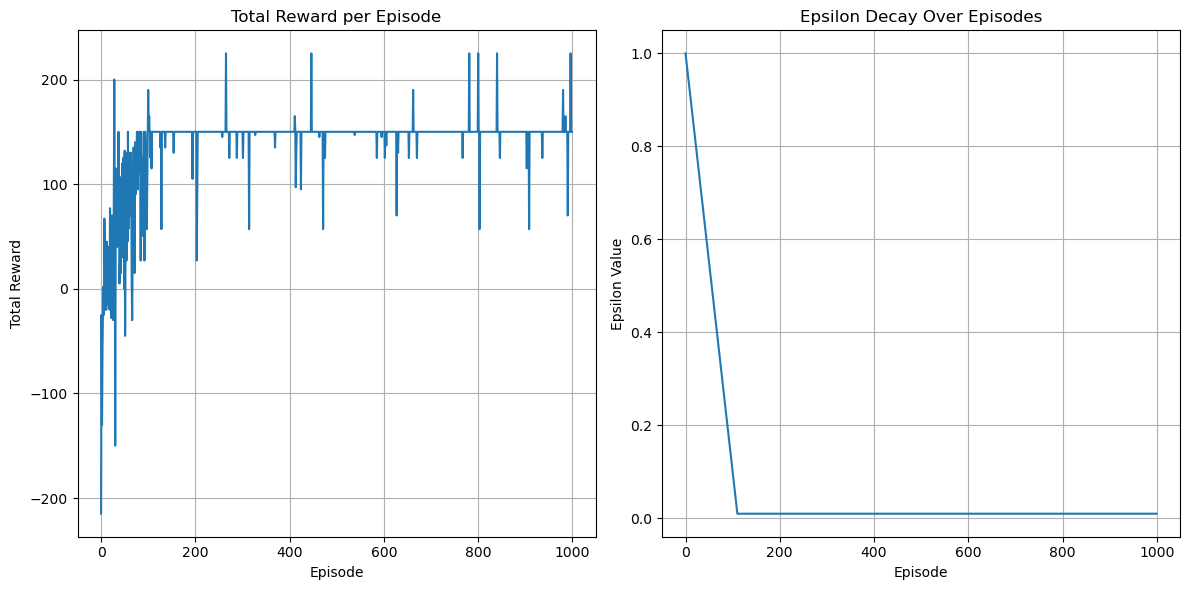

In [150]:
drawGraphs(totalEpisodesRewards, epsilonPerEpisode)

#### In case of only greedy action is taken

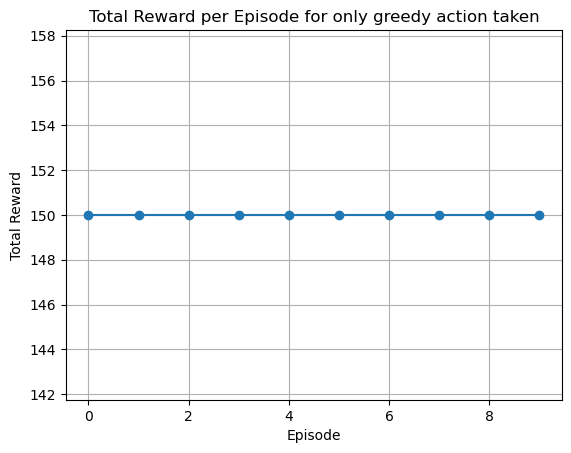

In [152]:
totalEpisodesRewards = doGreedyActionsWithTwoQs(Q1, Q2)
drawGraphForGreedyAction(totalEpisodesRewards)

### Second hyper parameter we are choosing is epsilonDecay

#### First try with epsilonDecay=0.001

In [177]:
Q1, Q2, totalEpisodesRewards, epsilonPerEpisode = doDoubleQLearn(epsilon = 1, total_episodes=1000, alpha=0.1, gamma=0.9, epsilonDecay=0.001)

Initial Q tables


Initial Q table 1
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]


Initial Q table 2
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]

Trained Q table


Trained Q table 1
[[199.85 121.12  74.96 132.86]
 [222.66 139.18 140.76 153.5 ]
 [248.84 162.77 117.64 166.52]
 [257.02 232.43 224.3  275.18]
 [117.64  15.73  16.73  27.43]
 [ 82.98  38.02  59.04 184.31]
 [ 67.27 157.8   17.36  70.76]
 [107.11  75.59  17.24 249.98]
 [ 40.94   5.01   7.35  13.71]
 [ 13.29  18.64  32.37 111.92]
 [  1.43  41.4   -3.41   3.7 ]
 [  0.     0.     0.     0.  ]]


Trained Q table 2
[[199.9  139.59  74.31 131.22]
 [223.36 126.55 136.17 151.98]
 [249.02 167.47 114.01 189.87]
 [253.71 228.85 230.86 270.12]
 [135.23  22.9   13.86  44.

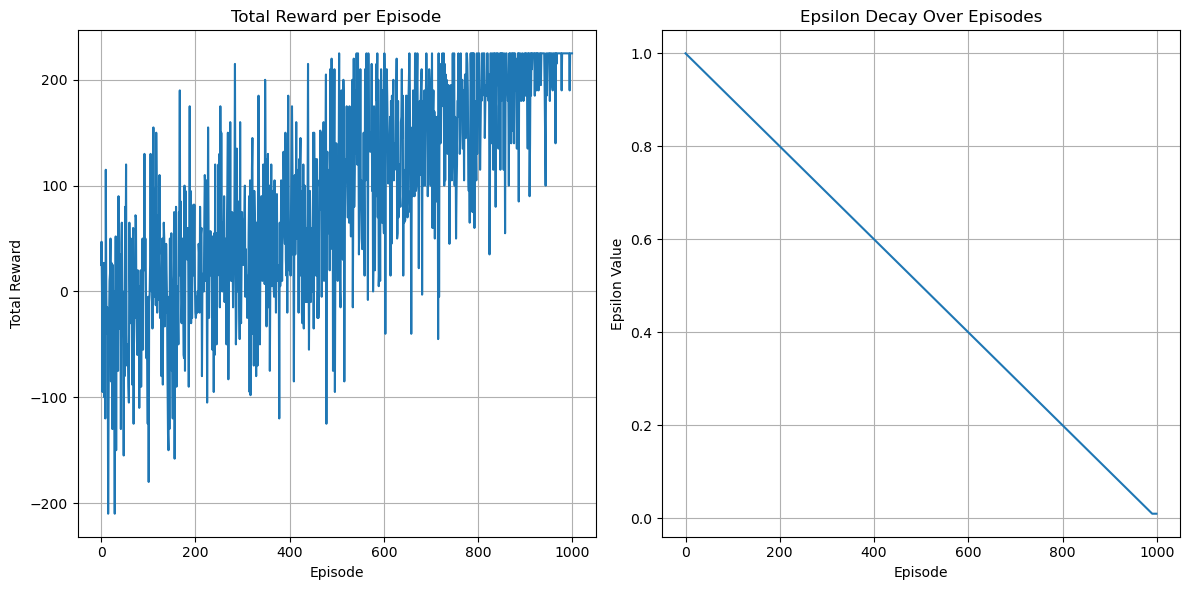

In [178]:
drawGraphs(totalEpisodesRewards, epsilonPerEpisode)

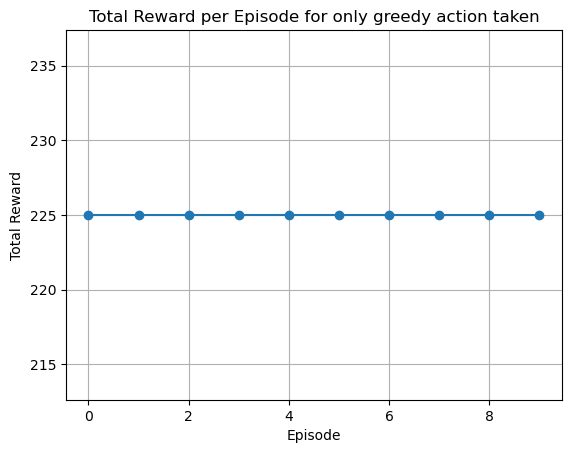

In [179]:
totalEpisodesRewards = doGreedyActionsWithTwoQs(Q1, Q2)
drawGraphForGreedyAction(totalEpisodesRewards)

#### Second try with epsilonDecay=0.06

In [180]:
Q1, Q2, totalEpisodesRewards, epsilonPerEpisode = doDoubleQLearn(epsilon = 1, total_episodes=1000, alpha=0.1, gamma=0.9, epsilonDecay=0.06)

Initial Q tables


Initial Q table 1
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]


Initial Q table 2
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]

Trained Q table


Trained Q table 1
[[ 7.985e+01  0.000e+00 -1.830e+00  1.200e-01]
 [ 4.000e-02  5.000e-01  8.856e+01  1.700e-01]
 [ 0.000e+00  8.722e+01  0.000e+00  1.070e+00]
 [ 0.000e+00  0.000e+00  4.020e+00  0.000e+00]
 [-4.500e-01 -1.640e+00 -9.500e-01 -5.000e-01]
 [ 8.704e+01  0.000e+00  0.000e+00  0.000e+00]
 [ 1.400e+00  1.770e+00  0.000e+00  8.508e+01]
 [ 0.000e+00  1.000e+00  0.000e+00 -3.700e-01]
 [ 0.000e+00 -5.000e-01  0.000e+00  0.000e+00]
 [ 6.000e-02 -5.500e-01  1.410e+00  0.000e+00]
 [ 7.000e-01 -5.000e-01  0.000e+00  0.000e+00]
 [ 0.000e+00  0.000e+00  0.

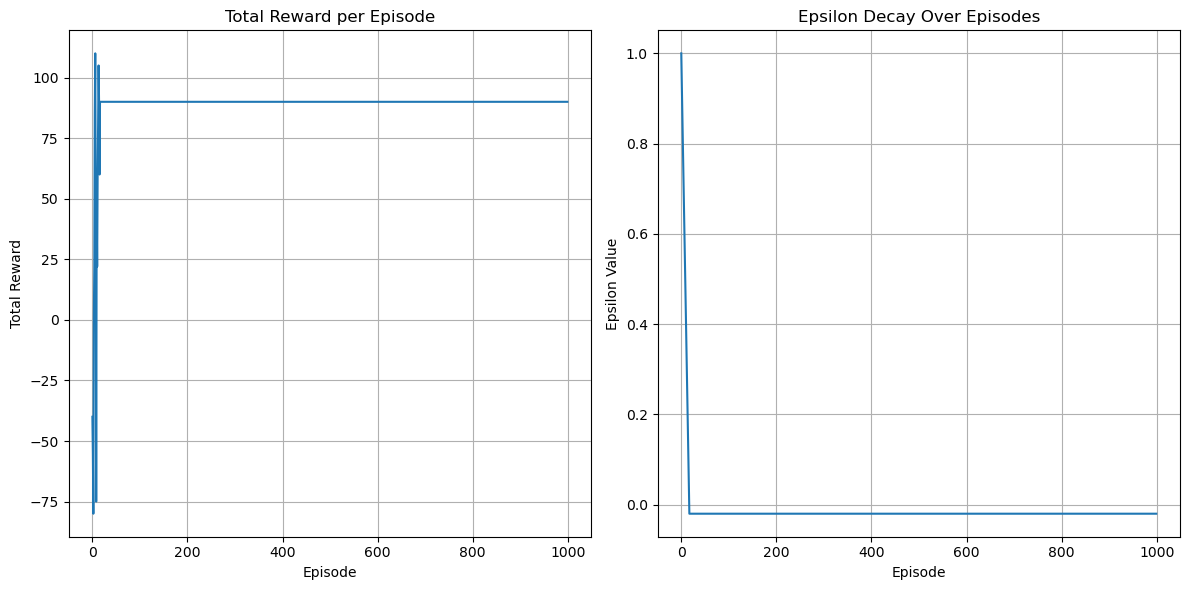

In [181]:
drawGraphs(totalEpisodesRewards, epsilonPerEpisode)

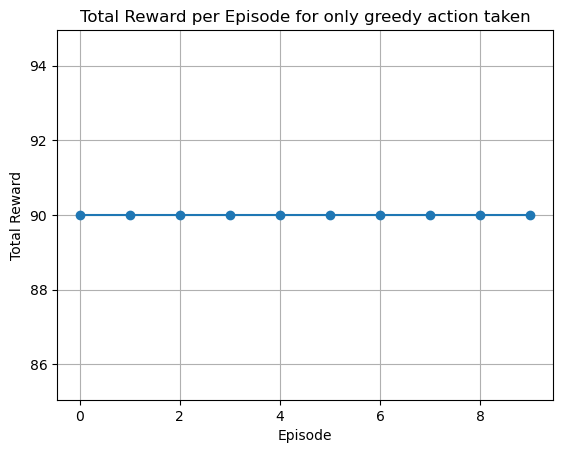

In [182]:
totalEpisodesRewards = doGreedyActionsWithTwoQs(Q1, Q2)
drawGraphForGreedyAction(totalEpisodesRewards)

#### Third try with epsilonDecay=0.0008

In [184]:
Q1, Q2, totalEpisodesRewards, epsilonPerEpisode = doDoubleQLearn(epsilon = 1, total_episodes=1000, alpha=0.1, gamma=0.9, epsilonDecay=0.0008)

Initial Q tables


Initial Q table 1
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]


Initial Q table 2
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]

Trained Q table


Trained Q table 1
[[113.18  83.62  75.98  85.9 ]
 [101.51  97.77 125.   113.22]
 [ 48.56 115.72  67.79  60.15]
 [ 20.98  82.51  24.24  28.48]
 [102.5   57.58  51.91  64.59]
 [109.97  97.42 117.44 125.59]
 [ 23.88 115.49  29.71  67.02]
 [ 17.27  13.49   8.61  31.05]
 [ 79.16   8.83  13.43  32.73]
 [ 35.57  47.72  77.47 117.99]
 [  1.37  79.18   4.12  29.06]
 [  0.     0.     0.     0.  ]]


Trained Q table 2
[[110.21  89.23  77.81  89.24]
 [106.16 103.82 125.16 109.61]
 [ 51.03 111.12  68.78  65.97]
 [ 25.91  61.2   16.49  32.78]
 [112.67  48.1   41.43  66.

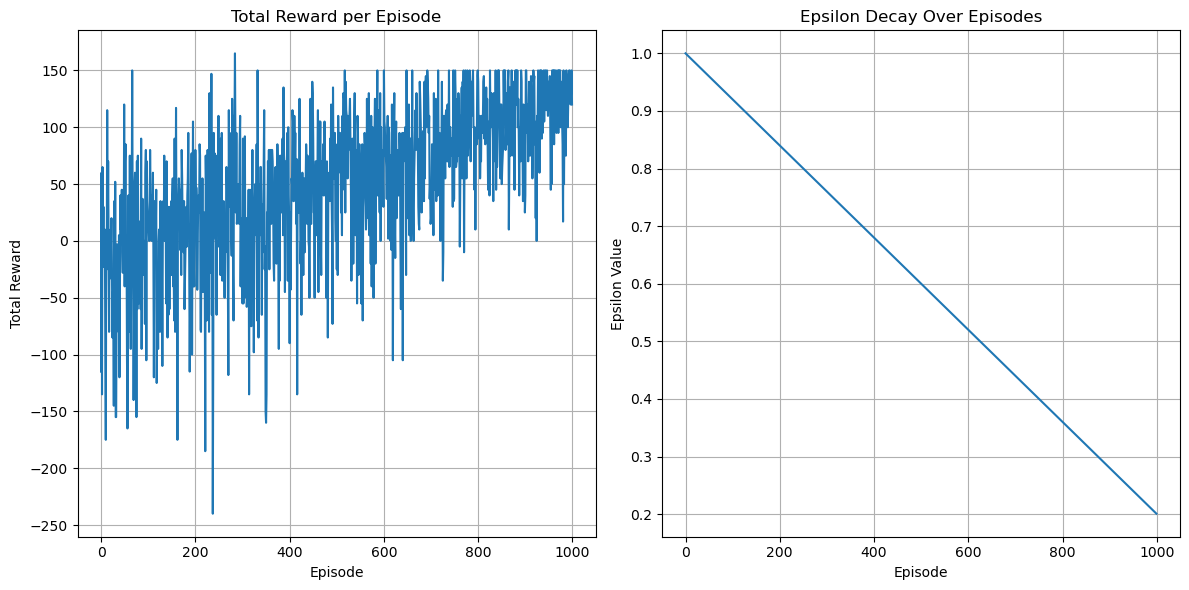

In [185]:
drawGraphs(totalEpisodesRewards, epsilonPerEpisode)

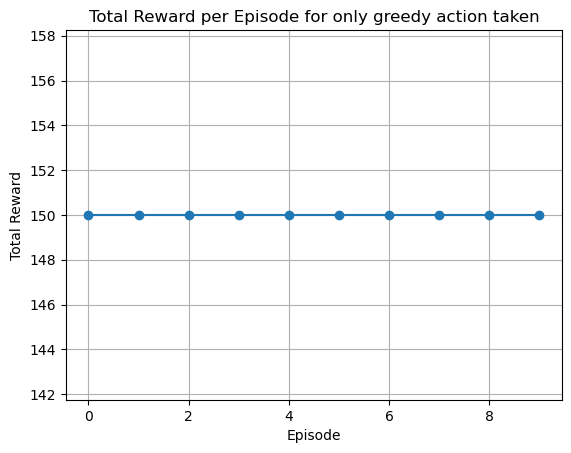

In [186]:
totalEpisodesRewards = doGreedyActionsWithTwoQs(Q1, Q2)
drawGraphForGreedyAction(totalEpisodesRewards)